In [1]:
import numpy as np
from scipy import *
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from xppcall import xpprun
import networkx as nx
import conley_functions as cf
import subprocess

In [2]:
delta = 1
epsilon = 0.4
#check legal:
print(epsilon<delta/(1+delta))
N=3
# W = -2*np.ones((N,N))
wi=-1-delta
we=-1+epsilon
W = np.array([[0,we,wi],
              [wi,0,we],
              [we,wi,0]])
# W = np.array([[0,wi,we,we,wi],
#               [we,0,wi,we,wi],
#               [wi,we,0,wi,wi],
#               [wi,wi,wi,0,we],
#               [wi,we,wi,wi,0]])
# W = np.array([[0,we,wi,we,wi],
#               [wi,0,wi,wi,we],
#               [wi,we,0,we,wi],
#               [wi,wi,wi,0,we],
#               [we,wi,we,wi,0]]).T
bs = np.ones(N)
dt=0.1
wcstring = cf.make_ctln(W, bs, dt=dt)
with open('ctln_p.ode', 'w') as f:
    f.writelines(wcstring)

True


<IPython.core.display.Javascript object>


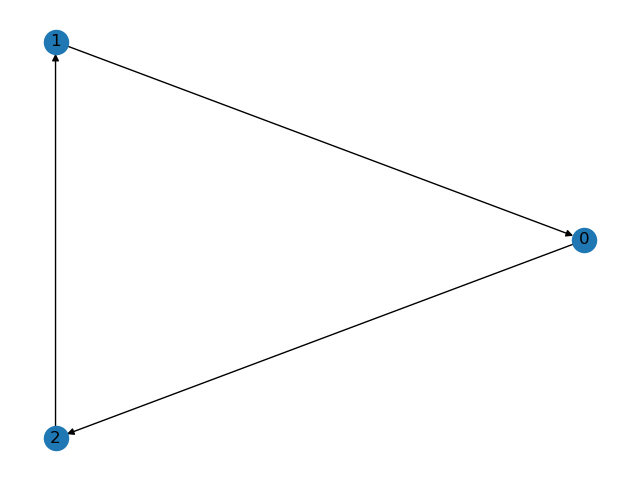

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [3]:
%matplotlib notebook

G=nx.from_numpy_matrix(np.where(np.logical_and(W>-1,W<0),1,0).T,create_using=nx.DiGraph())
nx.draw_circular(G, with_labels=True)
np.where(np.logical_and(W>-1,W<0),1,0).T

In [4]:
low=0;high=1;delta=.25
grid = cf.make_grid(N, low, high, delta)

In [47]:
len(grid)

125

In [5]:
%matplotlib notebook
time = 500
data = np.array([[0]*N])
data_length_list = []
for gc in grid:
    inits_dict={}
    for i,init in enumerate(gc):
        inits_dict['x'+str(i+1)]=init
    npa, vn = xpprun('ctln_p.ode', inits=inits_dict, parameters={'total':time}, clean_after=True)
    data = np.append(data, npa[:,1:], axis=0)  
    data_length_list.append(npa.shape[0])
#     plt.plot(npa[:,1])
data = data[1:,:]

In [6]:
# %matplotlib notebook

# plt.plot(data.reshape(len(grid), 10*time+1, N)[:,:,1], data.reshape(len(grid), 10*time+1, N)[:,:,2])

<IPython.core.display.Javascript object>


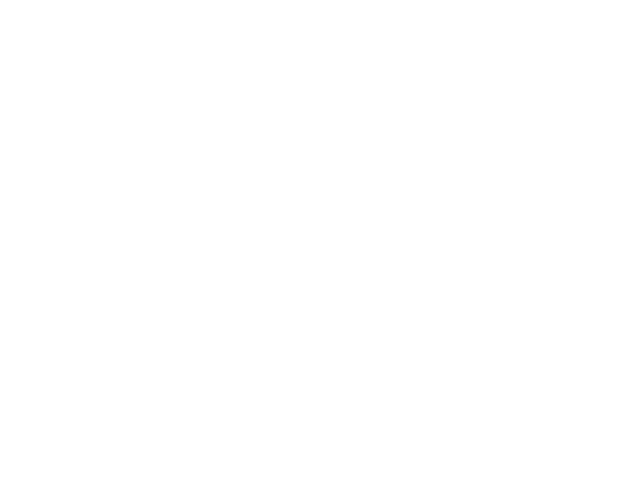

In [7]:
%matplotlib notebook
plt.plot(data[:,0], data[:,1])

In [8]:
nbins = 2**6
delta = 1/nbins
print(delta)
cds = cf.Combinatorial_Dynamical_System(delta)
cds.get_cubesandgraph(data, nbins, data_length_list, calc_matrix=True)

0.015625


In [9]:
RCs = cds.get_recurrent_components(includeselfedges=False)
print(len(RCs))

1


<IPython.core.display.Javascript object>


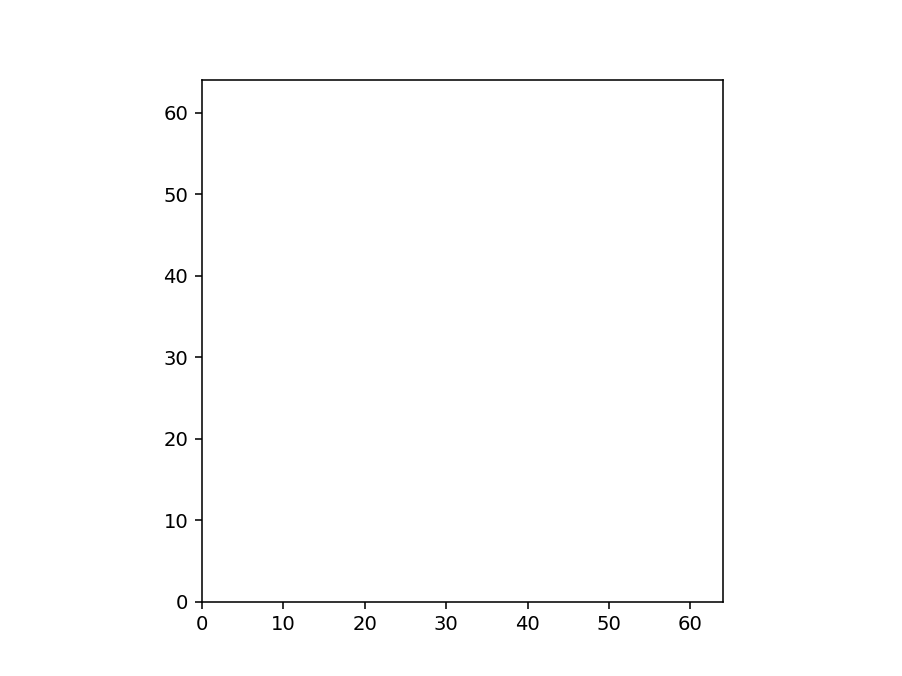

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(dpi=141)
xhi = nbins
xlo = 0
ax.set_xlim(xlo, xhi)
ax.set_ylim(xlo, xhi)

ax.set_aspect(1)
fig.canvas.draw()
s = max(1,((ax.get_window_extent().width  / (xhi-xlo+1.) *72./fig.dpi) ** 2))  

for i in range(len(RCs)):
    plt.scatter((np.array(RCs[i])[:,0]-delta),(np.array(RCs[i])[:,1]-delta), s=s, marker='s', label=i+1)
plt.show()

<IPython.core.display.Javascript object>


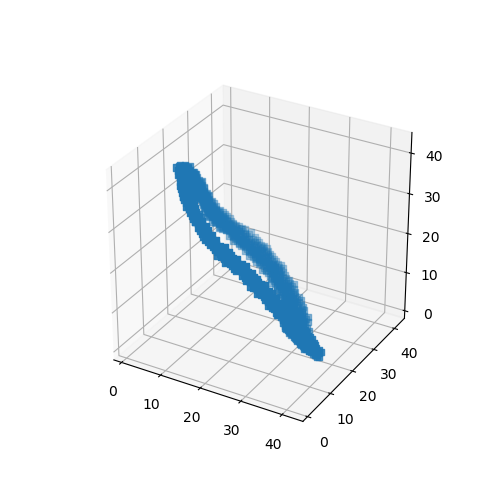

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(RCs)):
    ax.scatter((np.array(RCs[i])[:,0]-delta),(np.array(RCs[i])[:,1]-delta), (np.array(RCs[i])[:,2]-delta), marker='s', label=i+1)
plt.show()

In [149]:
RCs = cds.get_recurrent_components(includeselfedges=True)

RPcubes = {}

for i in range(0,len(RCs)):#range(0,1)
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(RCs[i])
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    Nbhd = RPcubes[i][0]
    print("Finding isolated nbhd")
    S = cds.invariantPart(Nbhd)
    M = cds.cubical_wrap(S).intersection(cds.G.nodes())
#     for mstep in range(1):
#         M = cds.cubical_wrap(M).intersection(cds.G.nodes())
    
    #calculate index pair
    try:
        print("Calculating index pair")
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        print("Calculating homology")
        
#         proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_map.map'%(i+1)],stdout=subprocess.PIPE)
#         proc = subprocess.Popen(['homcubes', '-i', 'rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
        proc = subprocess.Popen(['homcubes', '-i',
                                 'rc%s_P1_map.map'%(i+1), 
                                 'rc%s_P1_cubes.cub'%(i+1),
                                 'rc%s_P0_cubes.cub'%(i+1)], stdout=subprocess.PIPE)

        linenum = 0
#         print(proc.stdout.readlines())
        while True:
            line = proc.stdout.readline()
            if not line:
                break
#             print("           "+line.rstrip().decode('UTF-8'))
            if line.rstrip().decode('UTF-8')[0] in ['H', '	', 'D', 'F'] and not line.rstrip().decode('UTF-8')[1] == 'O':
#             if line.rstrip().decode('UTF-8')[0:2] == 'H_' or line.rstrip().decode('UTF-8')[0:2] == '  ' or line.rstrip().decode('UTF-8')[0:2] == 'Di':
                
                print("           "+line.rstrip().decode('UTF-8'))
            linenum+=1
            
    except Exception as e:
        if e=='too many values to unpack (expected 4)':
            print('Faile')
        else:
            print(e)

Component 1
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 2
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 3
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 4
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 5
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 6
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 7
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 8
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 9
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 10
Finding isolated nbhd
Calculating index pair
too many values to unpack (expected 4)
Component 11
Finding isolated nbhd


KeyboardInterrupt: 